In [2]:
import numpy as np 
import pandas as pd
import os
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D

In [3]:
# from tensorflow.keras.applications.densenet import DenseNet121

# model = DenseNet121(
#     weights=None, 
#     include_top=True,
#     input_shape=(256,256,3),
#     classes=256
# )

# # Expand this cell for the model summary
# model.summary()

In [4]:
# from tensorflow.keras.applications.resnet50 import ResNet50

# model = ResNet50(
#     weights=None, 
#     include_top=True,
#     input_shape=(256,256,3))

# # Expand this cell for the model summary
# model.summary()

In [5]:
from tensorflow.keras.applications.densenet import DenseNet121

denseModel = DenseNet121(
    weights=None, 
    include_top=True,
    input_shape=(256,256,3),
    classes=256
)

In [6]:
denseModel.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [7]:
# denseModel.save('test.h5')

# from keras.models import Model
from tensorflow.keras import Sequential

denseModel.layers.pop()
model2 = keras.Model(denseModel.input, denseModel.layers[-2].output)
# model2.summary()
model3 = keras.Model(model2.input, model2.layers[-2].output)
up = UpSampling2D(size=32,interpolation='bilinear',name='upsampling')
redCh = Convolution2D(filters=256,kernel_size=3,padding='same',name='conv2d')
final_model = Sequential()
final_model.add(model3)
final_model.add(up)
final_model.add(redCh)
final_model.add(BatchNormalization())
final_model.add(LeakyReLU(alpha=0.2))
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8, 8, 1024)        7037504   
_________________________________________________________________
upsampling (UpSampling2D)    (None, 256, 256, 1024)    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 256)     2359552   
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 256)     1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 256)     0         
Total params: 9,398,080
Trainable params: 9,313,920
Non-trainable params: 84,160
_________________________________________________________________


In [8]:
def pyramid_pooling_module(input_layer):
    # pyramid pooling module
    base = input_layer
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

In [9]:
def last_conv_module(input_layer):
    layer = input_layer.output
#     print(X.summary())
    layer = pyramid_pooling_module(layer)
    layer = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(layer)
    layer = BatchNormalization(name='last_conv_3_by_3_batch_norm')(layer)
    layer = Activation('sigmoid',name='last_conv_relu')(layer)
    layer = tf.keras.layers.Flatten(name='last_conv_flatten')(layer)
    return layer

In [10]:
input_layer = tf.keras.Input((256,256,3),name='input')
print(type(input_layer))
print(type(final_model.output))
# print(input_layer)

output_layer = last_conv_module(final_model)

# print(output_layer)

model = tf.keras.Model(inputs=final_model.input,outputs=output_layer)

# def last_conv_module2(input_layer):
#     X = pyramid_feature_maps(input_layer)
#     X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
#     X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
#     X = Activation('sigmoid',name='last_conv_relu')(X)
#     X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
#     return X
# Expand this cell for the model summary
model.summary()

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_1_input (InputLayer)      [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 8, 8, 1024)   7037504     model_1_input[0][0]              
__________________________________________________________________________________________________
upsampling (UpSampling2D)       (None, 256, 256, 102 0           model_1[1][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 256 2359552     upsampling[0][0]            

In [11]:
train_folder="cityscapes_data/cityscapes_data/train/"
valid_folder="cityscapes_data/cityscapes_data/val/"

In [12]:
def get_images_masks(path):
    names=os.listdir(path)
    img_g,img_m=[],[]
    for name in names:
        img=cv2.imread(path+name)
        img=cv2.normalize(img,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        img=img[:,:,::-1]
        img_g.append(img[:,:256])
        img_m.append(np.reshape(img[:,256:],(256*256*3)))
        del img
    del names
    return img_g,img_m

In [13]:
train_imgs,train_masks=get_images_masks(train_folder)
valid_imgs,valid_masks=get_images_masks(valid_folder)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='mse')
model.fit(np.array(train_imgs,dtype='float16'),np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs,dtype='float16'),np.array(valid_masks,dtype='float16')),
          epochs=20,steps_per_epoch=297,verbose=1,batch_size=1)
tf.keras.models.save_model(model,'dense_best_model.h5')

Train on 2975 samples, validate on 500 samples
Epoch 1/20
 297/2975 [=>............................] - ETA: 24:34 - loss: 0.0204 - val_loss: 0.0000e+00

In [14]:
model.load_weights('dense_best_model.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='mse')
model.fit(np.array(train_imgs,dtype='float16'),np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs,dtype='float16'),np.array(valid_masks,dtype='float16')),
          epochs=20,steps_per_epoch=297,verbose=1,batch_size=1)
tf.keras.models.save_model(model,'dense_best_model.h5')

Train on 2975 samples, validate on 500 samples
Epoch 1/20
 297/2975 [=>............................] - ETA: 23:54 - loss: 0.0172 - val_loss: 0.0000e+00

In [ ]:
# model.load_weights('dense_best_model.h5')
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='mse',metrics=[tf.keras.metrics.MeanIoU(num_classes=19)])
# model.fit(np.array(train_imgs,dtype='float16'),np.array(train_masks,dtype='float16'),
#           validation_data=(np.array(valid_imgs,dtype='float16'),np.array(valid_masks,dtype='float16')),
#           epochs=20,steps_per_epoch=297,verbose=1,batch_size=1)
# tf.keras.models.save_model(model,'dense_best_model.h5')

Train on 2975 samples, validate on 500 samples
Epoch 1/20


In [28]:
model.load_weights('dense_best_model.h5')
def plot(img,mask,pred):
    mask = np.reshape(mask,(256,256,3))
    pred = np.reshape(pred,(256,256,3))
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask)
    ax2.axis('off')
    ax3.imshow(pred)
    ax3.axis('off')

In [29]:
predictions = model.predict(np.array(valid_imgs,dtype='float16'),batch_size=1)

In [1]:
# def calc_IOU():
#     output = predictions[i]
#     target = valid_masks[i]
#     output = output.reshape((256,256,3)).copy()
#     target = target.reshape((256,256,3))
# #     output[np.where(target == ignore_index)[0]] = ignore_index
#     K  = 196608
#     intersection = output[np.where(output == target)[0]]
#     area_intersection, _ = np.histogram(intersection, bins=np.arange(K+1))
#     area_output, _ = np.histogram(output, bins=np.arange(K+1))
#     area_target, _ = np.histogram(target, bins=np.arange(K+1))
#     area_union = area_output + area_target - area_intersection
#     return area_intersection, area_union, area_target

In [30]:
#https://www.jeremyjordan.me/evaluating-image-segmentation-models/
iou_score = []
# print(valid_masks[0].shape)
# print(pred_masks[0].shape)
for i in range(500):
    mask = np.reshape(valid_masks[i],(256,256,3))
    pred = np.reshape(predictions[i],(256,256,3))
    mask = valid_masks[i]
    pred = predictions[i]
    intersection = np.logical_and(pred, valid_masks)
    union = np.logical_or(pred, mask)
    iou_score.append(np.sum(intersection) / np.sum(union))
# print(iou_score)
print(np.average(iou_score))

0.9193334669708421


In [ ]:
intersection = []
union = []
area = []
for i in range(500):
    a,b,c = calc_IOU(predictions[i],valid_masks[i])
    intersection.append(a)
    union.append(a)
    area.append(a)

In [ ]:
'''
https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/
https://en.wikipedia.org/wiki/Image_segmentation
https://paperswithcode.com/task/instance-segmentation
https://heartbeat.fritz.ai/a-2019-guide-to-semantic-segmentation-ca8242f5a7fc
https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4
https://www.youtube.com/watch?v=ZILIbUvp5lk&t=184s
https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a
https://medium.com/analytics-vidhya/semantic-segmentation-in-pspnet-with-implementation-in-keras-4843d05fc025
https://www.kaggle.com/santhalnr/cityscapes-image-segmentation-pspnet?source=post_page-----4843d05fc025----------------------
'''

-------------Input---------------Actual mask--------------Predicted mask-------
plotted


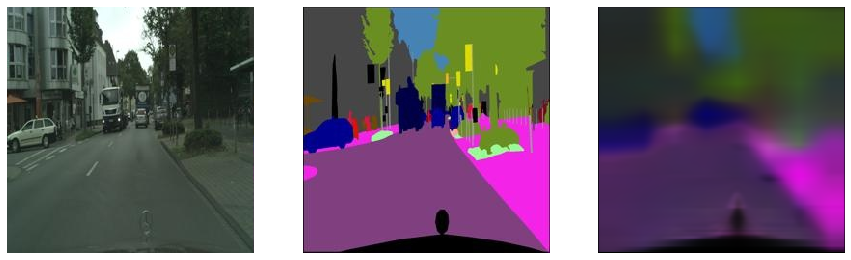

In [40]:
print('-------------Input---------------Actual mask--------------Predicted mask-------')
for i in range(1):
    x = np.random.randint(0,500,size=1)[0]
    plot(valid_imgs[x],valid_masks[x],predictions[x])
    print("plotted")

-------------Input---------------Actual mask--------------Predicted mask-------
plotted


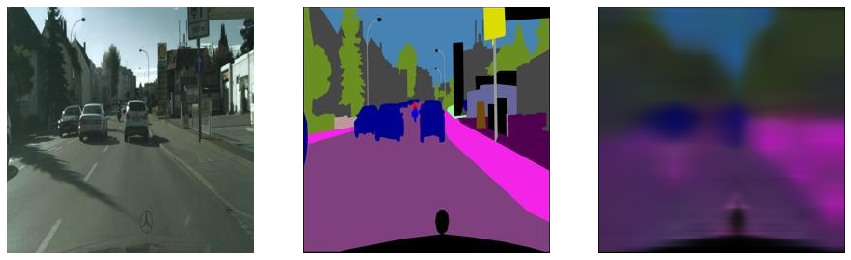

In [38]:
print('-------------Input---------------Actual mask--------------Predicted mask-------')
for i in range(1):
    x = np.random.randint(0,500,size=1)[0]
    plot(valid_imgs[x],valid_masks[x],predictions[x])
    print("plotted")

-------------Input---------------Actual mask--------------Predicted mask-------
plotted


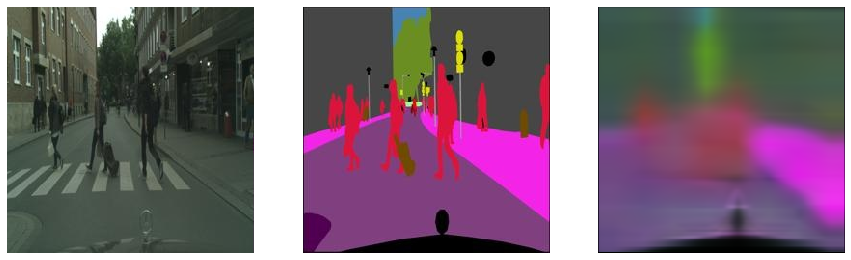

In [42]:
print('-------------Input---------------Actual mask--------------Predicted mask-------')
for i in range(1):
    x = np.random.randint(0,500,size=1)[0]
    plot(valid_imgs[x],valid_masks[x],predictions[x])
    print("plotted")